In [ ]:
# imports 
import pandas as pd
import numpy as np
from sklearn import model_selection, preprocessing
import torch.nn as nn
import torch
import torch.nn.functional as F
from torch import optim
import torchtext
import spacy
from sklearn.metrics import accuracy_score, roc_auc_score
from tqdm import tnrange, notebook
import matplotlib.pyplot as plt
import re
import string
from datetime import date
import zipfile

In [ ]:
ARGS = { 
    'random_state' : 42,
    'test_size' : 0.2,
    'base_nlp_dir' : '/content/drive/My Drive/NLP/',
    'batch_size' : 7,
    'lstm_hidden_dim' : 128,
    'lstm_layers' : 1,
    'dropout' : 0.2,
    'label_dim' : 4,
    'embeddings_dim' : 50,
    'num_epochs' : 200,
    'lr' : 1e-4,
    'patience' : 6,
    'attn_dropout': 0.2,
    'num_attention_layers' : 1
}
best_epoch = 0

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Load the data from csv

In [ ]:
allDataDf = pd.read_csv('/content/drive/My Drive/NLP/AllDataNumericalLabels.csv')
allDataDf = allDataDf.drop_duplicates(subset='text')
allDataDf = allDataDf.dropna()
allDataDf['label'] = allDataDf['label'].apply(lambda x : int(x))

In [ ]:
all_y = allDataDf['label']
all_X = allDataDf['text']

In [ ]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(all_X, all_y, 
                                                    test_size = ARGS['test_size'],
                                                    random_state = ARGS['random_state'])

X_train, X_val, y_train, y_val = model_selection.train_test_split(X_train, y_train, 
                                                    test_size = ARGS['test_size'],
                                                    random_state = ARGS['random_state'])

In [ ]:
print(len(X_train))
print(len(X_val))
print(len(X_test))

print(len(y_train))
print(len(y_val))
print(len(y_test))

In [ ]:
train_dataframe = pd.DataFrame({'text':X_train,'label':y_train})
val_dataframe = pd.DataFrame({'text':X_val,'label':y_val})
test_dataframe = pd.DataFrame({'text':X_test,'label':y_test})

In [ ]:
train_dataframe.to_csv('/content/drive/My Drive/NLP/train_df.csv', index=False)
val_dataframe.to_csv('/content/drive/My Drive/NLP/val_df.csv', index=False)
test_dataframe.to_csv('/content/drive/My Drive/NLP/test_df.csv', index=False)

## Load data to TabularDatasets

First, we declare what attributes (columns) in the dataframe we want to use and how to process them. Using torchtext.TabularDataset, and spaCy

In [ ]:
def clean_tweet(tweet):
  tweet = re.sub('http\S+|www.\S+|(^|[ ])(RT(?=\s))|@\S+', '',tweet) # remove URLS, retweets (RT), tags (@)
  tweet = re.sub('[,.;@#?!&$-]+\ *', ' ',tweet) # remove punctuation
  tweet = ''.join([i if ord(i) < 128 else ' ' for i in tweet]) # remove non-ascii chars
  return tweet.strip()

In [ ]:
preproc_pipeline = spacy.load('en', disable = ['parser', 'tagger', 'ner'])

In [ ]:
def tokenizer(tweet):
  return ([w.text.lower() for w in preproc_pipeline(clean_tweet(tweet))])

In [ ]:
# int label processing
txt_col = torchtext.data.Field(sequential=True, tokenize=tokenizer, include_lengths=True, use_vocab=True)
label_col = torchtext.data.Field(sequential=False, use_vocab=False, pad_token=None, unk_token=None)

In [ ]:
# string label processing
txt_col = torchtext.data.Field(sequential=True, tokenize=tokenizer ,include_lengths=True, use_vocab=True)
label_col = torchtext.data.Field(sequential=False, use_vocab=True, pad_token=None, unk_token=None)

In [ ]:
train_val_fields =[
                    ('text', txt_col),
                    ('label', label_col)
]

In [ ]:
train_ds, val_ds, test_ds = torchtext.data.TabularDataset.splits(path=ARGS['base_nlp_dir'], 
                                            format='csv', 
                                            train='train_df.csv', 
                                            validation='val_df.csv', 
                                            test='test_df.csv',
                                            fields=train_val_fields, 
                                            skip_header=True)

In [ ]:
train_ds, val_ds, test_ds = torchtext.data.TabularDataset.splits(path=ARGS['base_nlp_dir'], 
                                            format='csv', 
                                            train='train_df_str_label.csv', 
                                            validation='val_df_str_label.csv', 
                                            test='test_df_str_label.csv',
                                            fields=train_val_fields, 
                                            skip_header=True)

## BatchWrapper
since BucketIterator returns a Batch object instead of text index and labels directly and Batch object is not iterable unlike pytorch Dataloader,
we will wrap it with iterable wrapper around Batch Object that returns the desired data



In [ ]:
class BatchWrapper:
  def __init__(self, dl, x_field, y_field):
        self.dl, self.x_field, self.y_field = dl, x_field, y_field
        
  def __len__(self):
        return len(self.dl)
    
  def __iter__(self):
        for batch in self.dl:
            X = getattr(batch, self.x_field)
            y = getattr(batch, self.y_field)
            yield (X,y)

### Baseline model - BiLSTM + GloVe

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

Load GloVe vectors

In [ ]:
for i,e in enumerate(iter(test_ds.examples)):
  try:
    lab = e.label
  except:
    print(f'{i} : empty label, {e.text}')

351 : empty label, ['super', 'typhoon', ' ', 'bopha']
352 : empty label, ['five', 'day', 'forecast', 'map']


In [ ]:
# unzip embeddings from cached files
zip_ref = zipfile.ZipFile('/content/drive/My Drive/NLP/glove.twitter.27B.zip', 'r')
zip_ref.extractall('/content/sample_data/glove')
zip_ref.close()

In [ ]:
#@title Default title text
loaded_vectors = torchtext.vocab.Vectors(name='glove.twitter.27B.50d.txt',
                                   cache='/content/sample_data/glove/',
                                  max_vectors=10000)

In [ ]:
# txt_col.build_vocab(train_ds, val_ds, max_size=10000, vectors=loaded_vectors)
try:
  txt_col.build_vocab(train_ds, max_size=10000, vectors=loaded_vectors)
  label_col.build_vocab(train_ds)
except AttributeError as e:
  print(e)

'Example' object has no attribute 'label'


In [ ]:
for i in range (10):
  print(txt_col.vocab.itos[i])

<unk>
<pad>
 
the
in
:
to
of
a
  


Loading the data in batches with the same text length (BucketIterator)

In [ ]:
train_iter, val_iter = torchtext.data.BucketIterator.splits(datasets=(train_ds, val_ds),
                                                            batch_sizes=(ARGS['batch_size'],ARGS['batch_size']),
                                                            sort_key=lambda x : len(x.text),
                                                            device=device,
                                                            sort_within_batch=True
                                                            )

Wrap BucketIterator with the new BatchWrapper

In [ ]:
train_batch_wrapper = BatchWrapper(train_iter, 'text', 'label')
val_batch_wrapper = BatchWrapper(val_iter, 'text', 'label')

Define the model

In [ ]:
class SelfAttentionLayer(nn.Module):
  def __init__(self, input_size, num_layers=ARGS['num_attention_layers'], dropout=ARGS['attn_dropout']):
    super().__init__()
    self.input_size = input_size
    self.num_layers = num_layers
    self.dropout = dropout
    self.modules = []

    for i in range(self.num_layers - 1): # initialize n-1 layers
      self.modules.append(nn.Linear(self.input_size, self.input_size))
      self.modules.append(nn.ReLU())
      self.modules.append(nn.Dropout(self.dropout))
    
    # initialize last layer (must output single output)
    self.modules.append(nn.Linear(self.input_size, 1))
    self.modules.append(nn.ReLU())
    self.modules.append(nn.Dropout(self.dropout))

    self.attention = nn.Sequential(*self.modules)

    self.softmax = nn.Softmax(dim=0)

  def forward(self, inputs):
    # first, find the attention weights of each word(hidden state)
    attn_weights = self.attention(inputs)
    attn_shape = self.attention(inputs).shape
    attn_weights = attn_weights.reshape( attn_shape[0],  attn_shape[1])
    attn_weights = self.softmax(attn_weights)


    # multiply each word (hidden state) by its attention weight
    weighted_words = torch.mul(inputs, attn_weights.unsqueeze(-1).expand_as(inputs))
    weighted_sum = weighted_words.sum(dim=0).squeeze()

    return attn_weights, weighted_sum



In [ ]:
class BiLSTM(nn.Module):
  def __init__(self, pretrained_embeds, padding_idx, train_embeds=False,
               hidden_dim=ARGS['lstm_hidden_dim'], lstm_layers=ARGS['lstm_layers'], 
               dropout=ARGS['dropout'], embeddings_dim = ARGS['embeddings_dim']):
    super().__init__()
    self.hidden_dim = hidden_dim
    self.dropout = torch.nn.Dropout(p=dropout)
    self.embeddings = torch.nn.Embedding.from_pretrained(pretrained_embeds)
    self.embeddings.padding_idx = padding_idx
    self.num_layers = lstm_layers
    if not (train_embeds):
      self.embeddings.weight.requires_grad = False
    self.bilstm = torch.nn.LSTM(input_size=embeddings_dim,
                          hidden_size = self.hidden_dim,
                          dropout = dropout,
                          bidirectional = True)
    self.attention = SelfAttentionLayer(self.hidden_dim*2)
    self.fc = torch.nn.Linear(self.hidden_dim*2, ARGS['label_dim']) 

  def forward(self, sents):
    x = self.embeddings(sents)
    lstm_out ,(hidden_n, cell_n) = self.bilstm(x)
    attn_weights, weighted_words = self.attention(lstm_out)
    weights = self.fc(self.dropout(weighted_words))
    probs = F.softmax(weights, dim=-1)
    return (weights, probs, attn_weights) # since i use cross entropy loss, the softmax is performed in it (in the softmax). i return probs just for auc computation


In [ ]:
def fit(model, train_iter, val_iter, num_epochs, loss_func, opt, patience, is_gpu=False):
  batch_num = len(train_iter)
  plt.ion()
  min_val_loss = np.Inf
  epochs_no_val_improve = 0
  stop_early = False
  train_losses = list()
  train_accuracies = list()
  train_aucs = list()
  if val_iter:
    val_losses = list()
    val_accuracies = list()
    val_aucs = list()
  for epoch in notebook.tnrange(num_epochs, desc="epochs"):
    y_train_true_total = list()
    y_train_pred_total = list()
    y_train_probs_total = list()
    total_loss_train = 0
    train_batches = notebook.tqdm(iter(train_iter), leave=False, total=batch_num)
    
    ## train loop
    for (X_train, lengths_train), y_true_train in train_batches:
      model.train()
      train_batches.set_description(f'Epoch {epoch}')
      # if is_gpu:
      #   lengths_train = lengths_train.cpu().numpy()
      # else:
      #   lengths_train = lengths_train.numpy()
    
      opt.zero_grad()
      (weights_train, probs_train, attn_weights) = model(X_train)
      loss_train = loss_func(weights_train, y_true_train)
      loss_train.backward()
      opt.step()

      train_pred_idx = torch.max(weights_train, dim=1)[1]

      if is_gpu:
        y_train_true_total += list(y_true_train.cpu().data.numpy())
        y_train_pred_total += list(train_pred_idx.cpu().data.numpy())
        y_train_probs_total += list(probs_train.cpu().data.numpy())
      else:
        y_train_true_total += list(y_true_train.numpy())
        y_train_pred_total += list(train_pred_idx.numpy())
        y_train_probs_total += list(probs_train.numpy())
      total_loss_train += loss_train.item() # end of train batch

    train_auc = roc_auc_score(y_train_true_total, y_train_probs_total, multi_class='ovo' ,labels=[0,1,2,3])
    train_acc = accuracy_score(y_train_true_total, y_train_pred_total)
    train_loss = total_loss_train/batch_num

    train_aucs.append(train_auc)
    train_accuracies.append(train_acc)
    train_losses.append(train_loss) # end of train epoch

    ## val loop
    if val_iter:
      model.eval()
      y_val_true_total = list()
      y_val_pred_total = list()
      y_val_probs_total = list()
      total_loss_val = 0
      for (X_val,lengths_val), y_true_val in notebook.tqdm(iter(val_iter), leave=False):
        (weights_val, probs_val, attn_weights) = model(X_val)
        loss_val = loss_func(weights_val, y_true_val)
        val_pred_idx = torch.max(weights_val, dim=1)[1]


        if is_gpu:
          y_val_true_total += list(y_true_val.cpu().data.numpy())
          y_val_pred_total += list(val_pred_idx.cpu().data.numpy())
          y_val_probs_total += list(probs_val.cpu().data.numpy())
        else:
          y_val_true_total += list(y_true_val.numpy())
          y_val_pred_total += list(val_pred_idx.numpy())
          y_val_probs_total += list(probs_val.numpy())
        total_loss_val += loss_val.item() # end of val batch
      
      val_auc = roc_auc_score(y_val_true_total, y_val_probs_total, multi_class='ovo' ,labels=[0,1,2,3])
      val_acc = accuracy_score(y_val_true_total, y_val_pred_total)
      val_loss = total_loss_val/len(val_iter)

      # early stopping
      if (val_loss < min_val_loss):
        global best_epoch
        min_val_loss = val_loss
        epochs_no_val_improve = 0
        best_epoch = epoch
        torch.save(bilstm.state_dict(),f'/content/drive/My Drive/NLP/saved_models/bilstm_model_{date.today().strftime("%d-%m-%Y")}_state_dict_{epoch}')
      else:
        epochs_no_val_improve += 1
      if (epochs_no_val_improve == patience):
        print(f"Early stopping! best epoch = {best_epoch}")
        break


      val_aucs.append(val_auc)
      val_accuracies.append(val_acc)
      val_losses.append(val_loss)

      print(f'Epoch {epoch}: train_loss: {train_loss:.4f} train_acc: {train_acc:.4f} train_auc: {train_auc:.4f} | val_loss: {val_loss:.4f} val_acc: {val_acc:.4f} val_auc: {val_auc:.4f} min_val_loss: {min_val_loss:.4f}')
    else:
      print(f'Epoch {epoch}: train_loss: {train_loss:.4f} train_acc: {train_acc:.4f} train_auc: {train_auc:.4f} min_val_loss: {min_val_loss:.4f}')

    if (((epoch +1) % 5) == 0):
      fig, ((ax1),(ax2),(ax3)) = plt.subplots(3,1)

      ax1.plot(range(epoch+1),val_losses, color='b', label="val_loss", marker='o')

      ax1.plot(range(epoch+1),train_losses, color='g', label="train_loss",marker='o')
      ax1.set(title="loss")
      ax1.set(ylabel="loss")

      ax2.plot(range(epoch+1),val_accuracies, 'b', label="val_acc", marker='o')
      ax2.plot(range(epoch+1),train_accuracies, 'g', label="train_acc", marker='o')
      ax2.set(title="acc")
      ax2.set(ylabel="acc")


      ax3.plot(range(epoch+1),train_aucs, 'g' , label="train_auc", marker='o')
      ax3.plot(range(epoch+1),val_aucs, 'b',label="val_auc", marker='o')
      ax3.set(title="auc")
      ax3.set(ylabel="auc")

      ax1.legend()
      ax2.legend()
      ax3.legend()
      plt.show()


In [ ]:
bilstm = BiLSTM(pretrained_embeds=txt_col.vocab.vectors, padding_idx=txt_col.vocab.stoi[txt_col.pad_token]).to(device)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Epoch 0: train_loss: 0.9317 train_acc: 0.6120 train_auc: 0.6232 | val_loss: 0.8510 val_acc: 0.6736 val_auc: 0.6904 min_val_loss: 0.8510


Epoch 1: train_loss: 0.7586 train_acc: 0.7042 train_auc: 0.7192 | val_loss: 0.7828 val_acc: 0.7142 val_auc: 0.7297 min_val_loss: 0.7828


Epoch 2: train_loss: 0.7283 train_acc: 0.7170 train_auc: 0.7417 | val_loss: 0.7634 val_acc: 0.7117 val_auc: 0.7460 min_val_loss: 0.7634


Epoch 3: train_loss: 0.7070 train_acc: 0.7216 train_auc: 0.7623 | val_loss: 0.7444 val_acc: 0.7241 val_auc: 0.7615 min_val_loss: 0.7444


Epoch 4: train_loss: 0.6894 train_acc: 0.7290 train_auc: 0.7762 | val_loss: 0.7389 val_acc: 0.7266 val_auc: 0.7763 min_val_loss: 0.7389


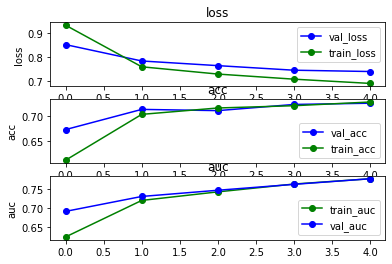

Epoch 5: train_loss: 0.6767 train_acc: 0.7330 train_auc: 0.7882 | val_loss: 0.7338 val_acc: 0.7283 val_auc: 0.7749 min_val_loss: 0.7338


Epoch 6: train_loss: 0.6638 train_acc: 0.7319 train_auc: 0.7973 | val_loss: 0.7227 val_acc: 0.7266 val_auc: 0.7814 min_val_loss: 0.7227


Epoch 7: train_loss: 0.6553 train_acc: 0.7417 train_auc: 0.8057 | val_loss: 0.7208 val_acc: 0.7299 val_auc: 0.7852 min_val_loss: 0.7208


Epoch 8: train_loss: 0.6504 train_acc: 0.7454 train_auc: 0.8081 | val_loss: 0.7223 val_acc: 0.7365 val_auc: 0.7838 min_val_loss: 0.7208


Epoch 9: train_loss: 0.6415 train_acc: 0.7470 train_auc: 0.8155 | val_loss: 0.7331 val_acc: 0.7341 val_auc: 0.7835 min_val_loss: 0.7208


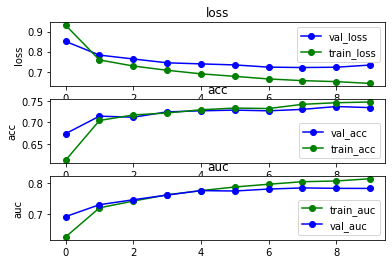

Epoch 10: train_loss: 0.6368 train_acc: 0.7487 train_auc: 0.8213 | val_loss: 0.7187 val_acc: 0.7423 val_auc: 0.7896 min_val_loss: 0.7187


Epoch 11: train_loss: 0.6256 train_acc: 0.7522 train_auc: 0.8273 | val_loss: 0.7091 val_acc: 0.7423 val_auc: 0.7966 min_val_loss: 0.7091


Epoch 12: train_loss: 0.6192 train_acc: 0.7537 train_auc: 0.8296 | val_loss: 0.7037 val_acc: 0.7415 val_auc: 0.7999 min_val_loss: 0.7037


Epoch 13: train_loss: 0.6144 train_acc: 0.7597 train_auc: 0.8342 | val_loss: 0.7084 val_acc: 0.7390 val_auc: 0.8051 min_val_loss: 0.7037


Epoch 14: train_loss: 0.6091 train_acc: 0.7589 train_auc: 0.8384 | val_loss: 0.6963 val_acc: 0.7448 val_auc: 0.8073 min_val_loss: 0.6963


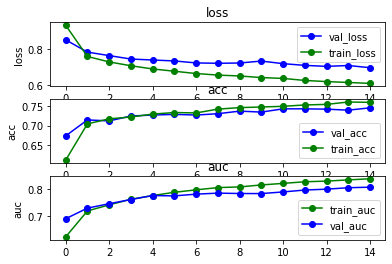

Epoch 15: train_loss: 0.6006 train_acc: 0.7647 train_auc: 0.8411 | val_loss: 0.7163 val_acc: 0.7390 val_auc: 0.8045 min_val_loss: 0.6963


Epoch 16: train_loss: 0.5953 train_acc: 0.7644 train_auc: 0.8468 | val_loss: 0.7062 val_acc: 0.7423 val_auc: 0.8072 min_val_loss: 0.6963


Epoch 17: train_loss: 0.5886 train_acc: 0.7721 train_auc: 0.8487 | val_loss: 0.6997 val_acc: 0.7473 val_auc: 0.8135 min_val_loss: 0.6963


Epoch 18: train_loss: 0.5805 train_acc: 0.7709 train_auc: 0.8535 | val_loss: 0.7107 val_acc: 0.7382 val_auc: 0.8102 min_val_loss: 0.6963


Epoch 19: train_loss: 0.5762 train_acc: 0.7783 train_auc: 0.8562 | val_loss: 0.7109 val_acc: 0.7448 val_auc: 0.8089 min_val_loss: 0.6963


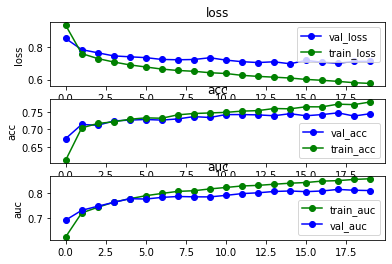

Early stopping! best epoch = 14


In [ ]:
opt = optim.Adam(filter(lambda p: p.requires_grad, bilstm.parameters()), ARGS['lr'])
fit(bilstm, train_batch_wrapper, val_batch_wrapper, ARGS['num_epochs'], F.cross_entropy, opt, ARGS['patience'], is_gpu=True)

## Inference

In [ ]:
best_epoch

14

### load pretrained model

In [ ]:
# load pretraind moedl
bilstm_loaded = BiLSTM(pretrained_embeds=txt_col.vocab.vectors, padding_idx=txt_col.vocab.stoi[txt_col.pad_token],train_embeds=False).to(device)
bilstm_loaded.load_state_dict(torch.load(f'/content/drive/My Drive/NLP/saved_models/bilstm_model_{date.today().strftime("%d-%m-%Y")}_state_dict_{best_epoch}',map_location=torch.device(device)))

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


<All keys matched successfully>

### prediction fucntions

In [ ]:
def predict_test_set(model, test_iter, loss_func, is_gpu=False):
  model.eval()
  y_test_true_total = list()
  y_test_pred_total = list()
  y_test_probs_total = list()
  test_aucs = list()
  test_accuracies = list()
  test_losses = list()
  total_loss_test = 0
  for (X_test,lengths_test), y_true_test in notebook.tqdm(iter(test_iter), leave=False):
    (weights_test, probs_test, attn_weights) = model(X_test)
    loss_test = loss_func(weights_test, y_true_test)
    test_pred_idx = torch.max(weights_test, dim=1)[1]

    if is_gpu:
      y_test_true_total += list(y_true_test.cpu().data.numpy())
      y_test_pred_total += list(test_pred_idx.cpu().data.numpy())
      y_test_probs_total += list(probs_test.cpu().data.numpy())
    else:
      y_test_true_total += list(y_true_test.numpy())
      y_test_pred_total += list(test_pred_idx.numpy())
      y_test_probs_total += list(probs_test.numpy())
    total_loss_test += loss_test.item() # end of val batch

  test_auc = roc_auc_score(y_test_true_total, y_test_probs_total, multi_class='ovo' ,labels=[0,1,2,3])
  test_acc = accuracy_score(y_test_true_total, y_test_pred_total)
  test_loss = total_loss_test/len(test_iter)

  test_aucs.append(test_auc)
  test_accuracies.append(test_acc)
  test_losses.append(test_loss)

  print(f'test_loss: {test_loss:.4f} test_acc: {test_acc:.4f} test_auc: {test_auc:.4f}')
  return()

In [ ]:
def predict_single_sentence(model, sent):
  model.eval()
  tokenized = tokenizer(sent)
  for (i, word) in enumerate(iter(tokenized)):
    print (f"i = {i}, word: {word}")
  indexed = [txt_col.vocab.stoi[t] for t in tokenized]
  tensor = torch.LongTensor(indexed).to(device)

  (weights_test, probs_test, attn_weights) = model(tensor.unsqueeze(dim=1))
  test_pred_idx = torch.max(weights_test, dim=-1)[1]
  plt.matshow(np.swapaxes(attn_weights.cpu().detach().numpy(),0,1)) 
  return test_pred_idx

### prepare test dataset

In [ ]:
test_iter = torchtext.data.BucketIterator(test_ds,
                                          batch_size=ARGS['batch_size'],
                                          sort_key=lambda x : len(x.text),
                                          device=device,
                                          sort_within_batch=True
                                          )

In [ ]:
test_batch_wrapper = BatchWrapper(test_iter, 'text', 'label')

In [ ]:
predict_test_set(bilstm_loaded,test_batch_wrapper,F.cross_entropy, is_gpu=True)

test_loss: 0.7127 test_acc: 0.7243 test_auc: 0.8026


()